In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

Подгружаем train_dataset.csv как 80% тренировочных данных, и test_dataset как 20% проверочных

In [31]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_dataset.csv')
d_train = pd.read_csv('../data/train_dataset.csv')
d_test = pd.read_csv('../data/test_dataset.csv')
full_data =(d_train,d_test)
# datetime_series = datetime_series.map(pd.Timestamp.timestamp)


объединяем столбцы даты и часа, чтобы можно было их выразить одним числом. Сначала приводим к типу datetime64 из дата первой колонки+временная дельта(часы) второй колонки

In [32]:
def make_dt_col(row_date,row_time):
    return pd.to_datetime(row_date)+pd.to_timedelta(row_time,unit='h')



t_series=d_train.apply(lambda x: make_dt_col(x['date'],x['time']),axis=1)
t_series

0       2019-01-01 00:00:00
1       2019-01-01 01:00:00
2       2019-01-01 02:00:00
3       2019-01-01 03:00:00
4       2019-01-01 04:00:00
                ...        
37219   2023-03-31 19:00:00
37220   2023-03-31 20:00:00
37221   2023-03-31 21:00:00
37222   2023-03-31 22:00:00
37223   2023-03-31 23:00:00
Length: 37224, dtype: datetime64[ns]

Переводим datetime в секунды и тип float

In [33]:
#преобразуем datetime во float , измерение в секундах
t_series=t_series.map(pd.Timestamp.timestamp)

задаем периоды на день и на год в секундах , переводим в радианы, и передаем как аргумент в синусоидные функции

In [34]:
day_in_secs = 24*60*60 
year_in_secs = (365.2425)*day_in_secs


d_train['Day sin'] = np.sin(t_series * (2 * np.pi / day_in_secs))
d_train['Day cos'] = np.cos(t_series * (2 * np.pi / day_in_secs))
d_train['Year sin'] = np.sin(t_series * (2 * np.pi / year_in_secs))
d_train['Year cos'] = np.cos(t_series * (2 * np.pi / year_in_secs))

Смотрим графики

Text(0.5, 1.0, 'Time of day signal')

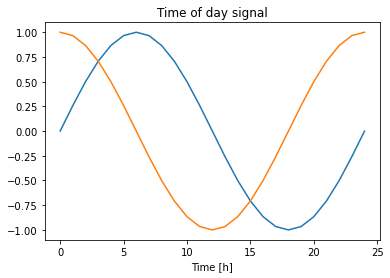

In [40]:
plt.plot(np.array(d_train['Day sin'])[:25])
plt.plot(np.array(d_train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Year signal')

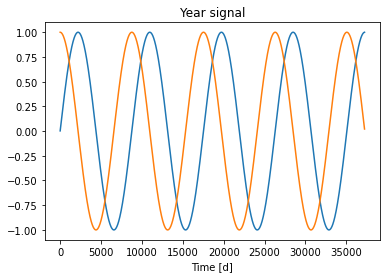

In [42]:
plt.plot(np.array(d_train['Year sin']))
plt.plot(np.array(d_train['Year cos']))
plt.xlabel('Time [d]')
plt.title('Year signal')

In [ ]:
from collections import Counter as Counter
import re

def see_word_count(df_col,split_delim = "[, ]+"):
  """
  Функция для оценки слов, которые можно выбрать для парсинга. Считает количество вхождений всех слов между делимитерами
  :df_col: - колонка датафрейма
  :split_delim: - по умолчанию '[, ]+' ,делит по 1 или более(если идут подряд) запятой и пробелу. Этот аргумент вставляется как паттерн регулярки для разделения строки
  """
  count_dict = Counter()
  df_col.apply(str).str.lower().apply(lambda row: re.split(f"{split_delim}",row)).apply(count_dict.update)
  return count_dict

def line_print_dict_by_value(some_dict):
  for word,count in sorted(some_dict.items(),key=lambda x : x[1],reverse=True):
    print(f"{word}:{count}")
print("Колонка с фактической погодой:")
fact_weather_word_count = see_word_count(d_train["weather_fact"],split_delim=",")
line_print_dict_by_value(fact_weather_word_count)
# print("\nКолонка с предсказанной погодой:")
# pred_wether_word_count =  see_word_count(data["weather_pred"])
# line_print_dict_by_value(pred_wether_word_count)



In [ ]:
d_train["target"].describe()


count    2928.000000
mean      419.467047
std        71.393070
min       264.819000
25%       371.384250
50%       431.477500
75%       462.414250
max       607.474000
Name: target, dtype: float64

In [ ]:
d_train.apply(lambda col: col.unique())

time            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
target          [479.282, 445.182, 424.225, 413.866, 408.146, ...
temp            [5.7, 5.0, 4.8, 6.5, 5.9, 4.5, 3.2, 2.3, 2.2, ...
temp_pred       [5.0, 4.0, 2.0, 1.0, 6.0, -1.0, 3.0, 0.0, -3.0...
weather_pred    [пасм, 58%, пасм, 71% дождь, пасм, 46% дождь, ...
weather_fact    [пасм, морось, пасм, дымка, пасмурно, ветерок,...
dtype: object

In [ ]:
def parse_weather_column(keywords:list,src_column_name:str,target_column_name:str,df):
  '''
  Функция для парсинга отдельных столбцов, ищет вхождение переданных ключевых слов в строке и пишет в новую колонку найденное  слово или пустую строку
  :keywords: -список ключевых слов. Ищутся по порядку перебором , поэтому лучше указывать сначала длинные слова, а потом их подстроки
  (например, если первым ключом будет "ветер", то вместо "ветерок" будет найден "ветер")
  :src_column_name: - название столбца, в котором идет поиск
  :target_column_name: - желаемое название нового столбца
  :df: - объект датафрейма, в котором  исходная колонка
  return копия датафрейма с добавленным новым столбцом(функция не inplace, перезаписывайте при надобности свой датафрейм)
  '''
  def find_kword(row_string):
      nonlocal keywords
      for k in keywords:
        if k in row_string:
          return k
      return ""
  found_list = [find_kword(row) for row in df[src_column_name] ]
  new_df = df.copy()
  new_df[target_column_name] = found_list
  return new_df

updated_wind  = parse_weather_column(["ветерок","ветрище","ветер"],"weather_fact","wind",d_train)

updated_wind.sample(10)

,time,target,temp,temp_pred,weather_pred,weather_fact,wind
date,,,,,,,
2023-04-29,6,362.546,6.4,9.0,"обл, неб.ветер",облачно,
2023-05-13,21,426.845,12.4,12.0,обл с пр,обл с пр,
2023-07-24,1,337.707,14.7,18.0,"обл с пр, 54% дождь","пасм, дождь",
2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось",
2023-06-02,17,430.204,11.8,13.0,пер.обл.,"малообл., ветер, очень холодно",ветер
2023-04-04,14,604.014,2.8,2.0,"пасм, 51% снег, ветер","облачно, ветерок",ветерок
2023-04-01,20,576.638,3.2,2.0,"пасм, 9% дождь","пасм, дождь",
2023-05-18,11,473.956,14.8,16.0,пасмурно,ясно,
2023-04-03,6,432.783,1.2,2.0,п/обл,"ясно, ветер",ветер


In [ ]:
updated_wind[["weather_fact","wind"]].sample(10)

,weather_fact,wind
date,,
2023-07-27,п/обл,
2023-07-19,облачно,
2023-05-28,малообл.,
2023-07-11,дымка,
2023-07-02,"дождь, ветер",ветер
2023-04-30,"п/обл, ветер",ветер
2023-06-14,"пасм, кр.дождь",
2023-05-26,"п/обл, ветер",ветер
2023-04-27,"п/обл, лед.крупа",


Переводим колонку ветра в числовой формат с нужной градацией силы ветра

In [ ]:
wind_map = {
    "": 0,
    "ветерок": 0.5,
    "ветер": 1,
    "ветрище":1.5
}
updated_wind["wind"]=updated_wind["wind"].map(wind_map)
updated_wind[["weather_fact","wind"]].sample(10)

,weather_fact,wind
date,,
2023-07-25,"пасмурно, ветерок",0.5
2023-05-21,"ясно, ветер",1.0
2023-05-07,"п/обл, ветерок",0.5
2023-05-05,ясно,0.0
2023-04-16,"пасм, слаб.дождь",0.0
2023-05-15,облачно,0.0
2023-07-01,дождь,0.0
2023-07-13,дымка,0.0
2023-04-03,"ясно, ветер",1.0
